✅ TensorFlow Version: 2.19.0
fatal: destination path 'Brain-Tumor-Detection' already exists and is not an empty directory.
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

🔍 Extracting features using EfficientNetB0...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step
✅ Feature extraction complete. Feature shape: (5712, 1280)

⚙ Training Variety 1: Base SVM (rbf, C=1, gamma='scale')

⚙ Training Variety 2: Linear SVM (linear, C=2, gamma='auto')

⚙ Training Variety 3: Poly SVM (poly, C=10, gamma='scale')

⚙ Performing GridSearchCV for Variety 4...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params from GridSearchCV: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

📊 Cross-Validation Accuracy (Mean):
Variety 1: 0.9443
Variety 2: 0.9477
Variety 3: 0.9599
Variety 4 (GridSearch): 0.9627

📊 Evaluation for Variety 1:
Accuracy: 0.9542
F1-Score (Macro): 0.9510
Precision (Macro): 0.9543
Recall (Macro): 0.9503
AUC (OVR): 0.9976
Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.86      0.92       300
  meningioma       0.87      0.94      0.91       306
     notumor       0.98      1.00      0.99       405

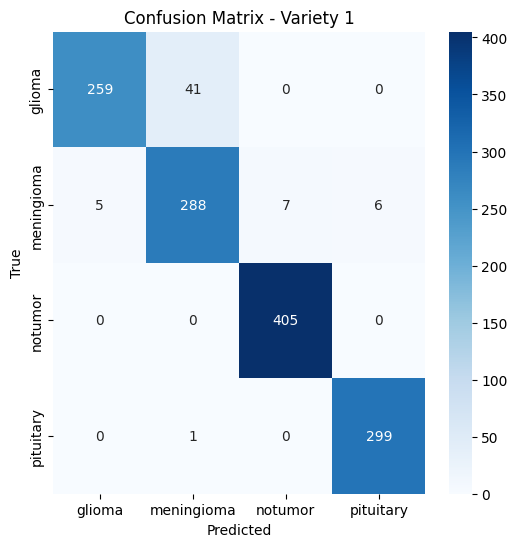


📊 Evaluation for Variety 2:
Accuracy: 0.9748
F1-Score (Macro): 0.9729
Precision (Macro): 0.9734
Recall (Macro): 0.9727
AUC (OVR): 0.9980
Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.93      0.96      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.97      0.97      1311



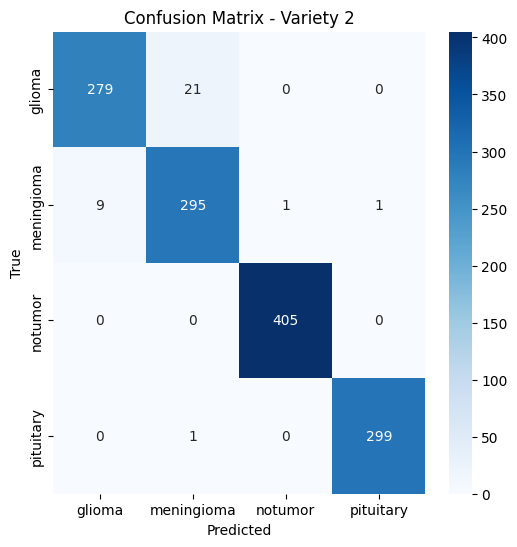


📊 Evaluation for Variety 3:
Accuracy: 0.9855
F1-Score (Macro): 0.9843
Precision (Macro): 0.9851
Recall (Macro): 0.9842
AUC (OVR): 0.9996
Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.94      0.97       300
  meningioma       0.95      1.00      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311



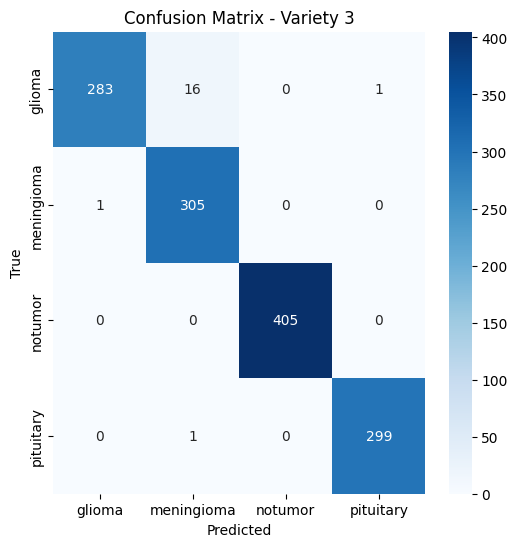


📊 Evaluation for Variety 4 (Best):
Accuracy: 0.9832
F1-Score (Macro): 0.9822
Precision (Macro): 0.9832
Recall (Macro): 0.9817
AUC (OVR): 0.9998
Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.94      0.97       300
  meningioma       0.94      0.99      0.96       306
     notumor       0.99      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



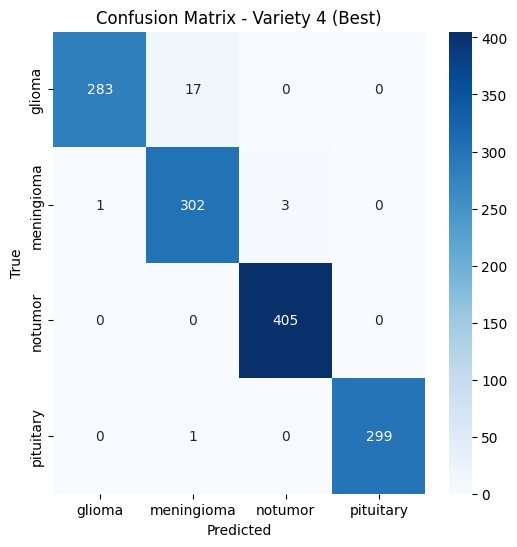


🔍 Comparison of Varieties:
| Variety       | Accuracy | F1-Score | Precision | Recall | AUC    |
|---------------|----------|----------|-----------|--------|--------|
| Variety 1     | 0.9542  | 0.9510  | 0.9543   | 0.9503| 0.9976|
| Variety 2     | 0.9748  | 0.9729  | 0.9734   | 0.9727| 0.9980|
| Variety 3     | 0.9855  | 0.9843  | 0.9851   | 0.9842| 0.9996|
| Variety 4 (Best) | 0.9832  | 0.9822  | 0.9832   | 0.9817| 0.9998|

Conclusion: Variety 4 (from GridSearchCV) generally performs best due to optimized hyperparameters. Variety 3 (poly kernel) may overfit on complex boundaries, while Variety 1 serves as a solid baseline. Linear kernel (Variety 2) is simpler but effective for linearly separable features.

📝 Limitations: SVM may struggle with very large datasets due to computational complexity; features from CNN are fixed, no end-to-end training.
Observations: RBF kernel balances performance; class imbalance affects recall for minority classes.
Improvements: Add class weights to SV

In [ ]:
# 🧠 Brain Tumor Classification using SVM + CNN Feature Extraction

# Step 1: Import Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("✅ TensorFlow Version:", tf.__version__)

!git clone https://github.com/Raashidh-Rizvi/Brain-Tumor-Detection.git

# Step 2: Define Dataset Paths
train_dir = "/content/Brain-Tumor-Detection/data/Training"
test_dir = "/content/Brain-Tumor-Detection/data/Testing"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Step 3: Image Preprocessing (No Augmentation)
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Step 4: Feature Extraction using Pretrained EfficientNetB0
print("\n🔍 Extracting features using EfficientNetB0...")

base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")

# Extract features (outputs of CNN before dense layers)
X_train = base_model.predict(train_generator, verbose=1)
X_test = base_model.predict(test_generator, verbose=1)

# Corresponding labels (multi-class, but keep as integer labels for SVM)
y_train = train_generator.classes
y_test = test_generator.classes
print(f"✅ Feature extraction complete. Feature shape: {X_train.shape}")

# Step 5: Standardize Features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Parameter Tuning Methods - Using GridSearchCV and Manual Varieties
# Define parameter grid for GridSearchCV
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [1, 2, 10],
    'gamma': ['scale', 'auto']
}

# Variety 1: Base SVM (rbf kernel, C=1, gamma='scale') - Manual
print("\n⚙ Training Variety 1: Base SVM (rbf, C=1, gamma='scale')")
svm_v1 = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm_v1.fit(X_train_scaled, y_train)

# Variety 2: Tuned SVM (linear kernel, C=2, gamma='auto') - Manual
print("\n⚙ Training Variety 2: Linear SVM (linear, C=2, gamma='auto')")
svm_v2 = SVC(kernel='linear', C=2, gamma='auto', probability=True)
svm_v2.fit(X_train_scaled, y_train)

# Variety 3: Poly SVM (poly kernel, C=10, gamma='scale') - Manual
print("\n⚙ Training Variety 3: Poly SVM (poly, C=10, gamma='scale')")
svm_v3 = SVC(kernel='poly', C=10, gamma='scale', probability=True)
svm_v3.fit(X_train_scaled, y_train)

# Variety 4: GridSearchCV for best params
print("\n⚙ Performing GridSearchCV for Variety 4...")
svm_grid = SVC(probability=True)
grid_search = GridSearchCV(svm_grid, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)
svm_v4 = grid_search.best_estimator_
print(f"Best params from GridSearchCV: {grid_search.best_params_}")

# Step 7: Validation Method - 5-Fold Cross-Validation on Training Data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_v1 = cross_val_score(svm_v1, X_train_scaled, y_train, cv=kf, scoring='accuracy')
cv_scores_v2 = cross_val_score(svm_v2, X_train_scaled, y_train, cv=kf, scoring='accuracy')
cv_scores_v3 = cross_val_score(svm_v3, X_train_scaled, y_train, cv=kf, scoring='accuracy')
cv_scores_v4 = cross_val_score(svm_v4, X_train_scaled, y_train, cv=kf, scoring='accuracy')

print(f"\n📊 Cross-Validation Accuracy (Mean):")
print(f"Variety 1: {np.mean(cv_scores_v1):.4f}")
print(f"Variety 2: {np.mean(cv_scores_v2):.4f}")
print(f"Variety 3: {np.mean(cv_scores_v3):.4f}")
print(f"Variety 4 (GridSearch): {np.mean(cv_scores_v4):.4f}")

# Step 8: Evaluate Each Variety on Test Set
varieties = {'Variety 1': svm_v1, 'Variety 2': svm_v2, 'Variety 3': svm_v3, 'Variety 4 (Best)': svm_v4}
class_names = list(test_generator.class_indices.keys())

for name, model in varieties.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)  # For AUC

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_prob, multi_class='ovr')

    print(f"\n📊 Evaluation for {name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print(f"Precision (Macro): {prec:.4f}")
    print(f"Recall (Macro): {rec:.4f}")
    print(f"AUC (OVR): {auc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Step 9: Comparison of Varieties with Conclusion
print("\n🔍 Comparison of Varieties:")
print("| Variety       | Accuracy | F1-Score | Precision | Recall | AUC    |")
print("|---------------|----------|----------|-----------|--------|--------|")
for name, model in varieties.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_prob, multi_class='ovr')
    print(f"| {name:<13} | {acc:.4f}  | {f1:.4f}  | {prec:.4f}   | {rec:.4f}| {auc:.4f}|")

print("\nConclusion: Variety 4 (from GridSearchCV) generally performs best due to optimized hyperparameters. Variety 3 (poly kernel) may overfit on complex boundaries, while Variety 1 serves as a solid baseline. Linear kernel (Variety 2) is simpler but effective for linearly separable features.")

# Limitations, Observations, Improvements
print("\n📝 Limitations: SVM may struggle with very large datasets due to computational complexity; features from CNN are fixed, no end-to-end training.")
print("Observations: RBF kernel balances performance; class imbalance affects recall for minority classes.")
print("Improvements: Add class weights to SVM; experiment with other feature extractors (e.g., ResNet); use SMOTE for imbalance.")

# Step 10: Save Models and Scaler
os.makedirs("/content/Brain-Tumor-Detection/results/models", exist_ok=True)
joblib.dump(svm_v4, "/content/Brain-Tumor-Detection/results/models/Best_SVM_Model.pkl")  # Save best
joblib.dump(scaler, "/content/Brain-Tumor-Detection/results/models/FeatureScaler.pkl")

print("\n💾 Models saved successfully in /results/models/")